In [1]:
import torch
import torch.utils.data
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Is CUDA Available?: ",torch.cuda.is_available())

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102
Is CUDA Available?:  True


In [2]:
cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, 'hotdog-nothotdog')
NUM_CLASSES = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 50
IS_SHUFFLE = True
NUM_EPOCHS = 25

In [3]:
def get_data(path: str, batch_size: int = 50, image_size: int = 299):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
    ])
    training_dataset = torchvision.datasets.ImageFolder(root=os.path.join(path, 'train'),
                                transform=preprocess)
    testing_dataset = torchvision.datasets.ImageFolder(root=os.path.join(path, 'test'),
                                transform=preprocess)
    training_dataloader = torch.utils.data.DataLoader(training_dataset,
                            batch_size=batch_size,
                            shuffle=IS_SHUFFLE)
    testing_dataloader = torch.utils.data.DataLoader(testing_dataset,
                            batch_size=batch_size,
                            shuffle=IS_SHUFFLE)

    return (training_dataloader, testing_dataloader)

training_dataloader , testing_dataloader = get_data(path=DATA_DIR, batch_size=BATCH_SIZE)

In [4]:
def get_network(pretrained: bool=True):
    network = models.googlenet(pretrained=pretrained, aux_logits=True)
    if torch.cuda.is_available():
        network = network.cuda()
    network.fc = nn.Linear(in_features=1024, out_features=NUM_CLASSES, bias=True)
    network.aux1.fc2 = nn.Linear(in_features=1024, out_features=NUM_CLASSES)
    network.aux2.fc2 = nn.Linear(in_features=1024, out_features=NUM_CLASSES)
    network
    return network

pretrained_network = get_network()
pretrained_network

/users/PAS2168/richkirk/.local/lib/python3.7/site-packages/torchvision/models/googlenet.py:296: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  "auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them"


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
def get_metrics(network, dataloader):
    count = 0
    correct = 0
    loss = 0
    network.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch[0]
            labels = batch[1]
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
                network = network.cuda()
            preds = network(images)
            batch_correct = preds.argmax(dim=1).eq(labels).sum().item()
            batch_count = len(batch[0])
            count += batch_count
            correct += batch_correct
            loss += F.cross_entropy(preds, labels)
    loss /= len(dataloader)
    network.train()
    return (correct/count, loss)

In [6]:
def train(optimizer, criterion, network, dataloader, test_dataloader):
    train_acc, test_acc = [], []
    network.train()
    for epoch in range(1, NUM_EPOCHS + 1):
        for batch in dataloader:
            images = batch[0]
            labels = batch[1]
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
                network = network.cuda()
            preds, aux_outputs_2, aux_outputs_1 = network(images)
            loss1 = criterion(preds, labels)
            loss2 = criterion(aux_outputs_2, labels)
            loss3 = criterion(aux_outputs_1, labels)
            loss = loss1 + 0.3*(loss2 + loss3)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        accuracy, loss = get_metrics(network, dataloader)
        train_acc.append(accuracy)
        print(
            f'Epoch {epoch}/{NUM_EPOCHS}: Train Loss: {loss}, Train Accuracy: {accuracy}')
        test_accuracy, test_loss = get_metrics(network, test_dataloader)
        test_acc.append(test_accuracy)
        print(
            f'Epoch {epoch}/{NUM_EPOCHS}: Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n')
    return (network, train_acc, test_acc)


In [7]:
pretrained_optimizer = optim.Adam(pretrained_network.parameters(), lr=LEARNING_RATE)
pretrained_criterion = nn.CrossEntropyLoss()
pretrained_network, pretrained_train_acc, pretrained_test_acc = train(pretrained_optimizer, pretrained_criterion, pretrained_network, training_dataloader, testing_dataloader)
torch.save(pretrained_network.state_dict(), os.path.join(cwd, 'model/PRETRAINED_MODEL'))
print("Pretrained Model Training Accuracy: ",pretrained_train_acc)
print("Pretrained Model Test Accuracy: ",pretrained_test_acc)

/users/PAS2168/richkirk/.local/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1/25: Train Loss: 0.20494025945663452, Train Accuracy: 0.923
Epoch 1/25: Test Loss: 0.2697930932044983, Test Accuracy: 0.8773291925465838

Epoch 2/25: Train Loss: 0.24984261393547058, Train Accuracy: 0.891
Epoch 2/25: Test Loss: 0.5418278574943542, Test Accuracy: 0.7996894409937888

Epoch 3/25: Train Loss: 0.07125876843929291, Train Accuracy: 0.9743333333333334
Epoch 3/25: Test Loss: 0.38825616240501404, Test Accuracy: 0.8788819875776398

Epoch 4/25: Train Loss: 0.16731946170330048, Train Accuracy: 0.9433333333333334
Epoch 4/25: Test Loss: 0.726439356803894, Test Accuracy: 0.8338509316770186

Epoch 5/25: Train Loss: 0.14199741184711456, Train Accuracy: 0.9466666666666667
Epoch 5/25: Test Loss: 0.6386253833770752, Test Accuracy: 0.8322981366459627

Epoch 6/25: Train Loss: 0.09083050489425659, Train Accuracy: 0.9663333333333334
Epoch 6/25: Test Loss: 0.6404401063919067, Test Accuracy: 0.8338509316770186

Epoch 7/25: Train Loss: 0.649284839630127, Train Accuracy: 0.8176666666666667


In [8]:
scratch_network = get_network(pretrained=False)
scratch_optimizer = optim.Adam(scratch_network.parameters(), lr=LEARNING_RATE)
scratch_criterion = nn.CrossEntropyLoss()
scratch_network, scratch_train_acc, scratch_test_acc = train(scratch_optimizer, scratch_criterion, scratch_network, training_dataloader, testing_dataloader)
torch.save(scratch_network.state_dict(), os.path.join(cwd, 'model/SCRATCH_MODEL'))
print("Scratch Model Training Accuracy: ",scratch_train_acc)
print("Scratch Model Test Accuracy: ",scratch_test_acc)

/users/PAS2168/richkirk/.local/lib/python3.7/site-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Epoch 1/25: Train Loss: 0.6132108569145203, Train Accuracy: 0.6626666666666666
Epoch 1/25: Test Loss: 0.6217954754829407, Test Accuracy: 0.6661490683229814

Epoch 2/25: Train Loss: 0.7343006730079651, Train Accuracy: 0.626
Epoch 2/25: Test Loss: 0.7563521862030029, Test Accuracy: 0.6319875776397516

Epoch 3/25: Train Loss: 0.7215414643287659, Train Accuracy: 0.6783333333333333
Epoch 3/25: Test Loss: 0.7679304480552673, Test Accuracy: 0.6428571428571429

Epoch 4/25: Train Loss: 0.5823884606361389, Train Accuracy: 0.755
Epoch 4/25: Test Loss: 0.6404688954353333, Test Accuracy: 0.7142857142857143

Epoch 5/25: Train Loss: 0.47234678268432617, Train Accuracy: 0.7853333333333333
Epoch 5/25: Test Loss: 0.569025456905365, Test Accuracy: 0.7220496894409938

Epoch 6/25: Train Loss: 0.5106042623519897, Train Accuracy: 0.7593333333333333
Epoch 6/25: Test Loss: 0.6030207872390747, Test Accuracy: 0.7220496894409938

Epoch 7/25: Train Loss: 0.464293509721756, Train Accuracy: 0.7763333333333333
Epoch 

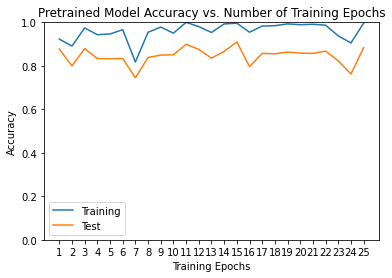

In [9]:
plt.title("Pretrained Model Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),pretrained_train_acc,label="Training")
plt.plot(range(1,NUM_EPOCHS+1),pretrained_test_acc,label="Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

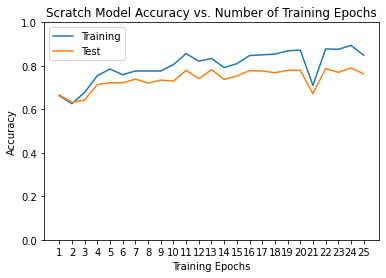

In [10]:
plt.title("Scratch Model Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),scratch_train_acc,label="Training")
plt.plot(range(1,NUM_EPOCHS+1),scratch_test_acc,label="Test")
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

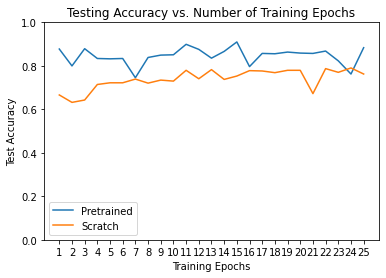

In [11]:
plt.title("Testing Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Test Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),pretrained_test_acc,label="Pretrained")
plt.plot(range(1,NUM_EPOCHS+1),scratch_test_acc,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()